# RNA sequencing data

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

import my_functions as fun

pd.set_option('display.max_columns', 25)

## Load data

This dataframe contains the read counts of each gene for the chosen sample.

In [2]:
def file_path_to_df(file_path: str):
    '''This function builds a dataframe from a tab separated txt file of which the file path is given.'''

    # open .txt file and read text 
    f = open((file_path), 'r')
    content = f.read()
    f.close()

    # split text into lines and tabs
    output = content.split('\n')
    output = [n.split('\t') for n in output]

    # discard first row (contains description) and last row (no data)
    del output[0]
    del output[-1]

    # create dataframe
    df_seq_data = pd.DataFrame(output)

    # identify first row as column names
    df_seq_data.columns = df_seq_data.iloc[0]
    df_seq_data = df_seq_data.drop(0)
    
    # extract file name 
    file_name = os.path.basename(file_path).replace("180087_", "").replace("_NCBI.txt", "")

    # replace column name read counts
    df_seq_data.rename(columns = {df_seq_data.columns[6]: file_name}, inplace=True)
    
    return df_seq_data

In [3]:
def files_to_dfs(source_dir: str):
    '''This function combines the gene counts of all txt files in a given directory into one dataframe.'''
    
    # build a list of file paths of the directory
    list_file_paths = [os.path.join(source_dir, x) for x in os.listdir(source_dir) if x.endswith(".txt")]
   
    # build a dataframe for each file and collect in a list of dataframes
    list_df_seq_data = []
    
    # initialize dataframe of gene counts
    df_com = file_path_to_df(list_file_paths[0])
    
    for file_path in list_file_paths:
        
        # build dataframe from given file path
        df_seq_data = file_path_to_df(file_path)
        
        # add column of gene counts to combined data frame
        df_com[df_seq_data.columns[6]] = df_seq_data[df_seq_data.columns[6]].astype(int)
    
    # add column of gene numbers
    df_com.insert(1, "gene_number", df_com["Geneid"].str.replace("CGZ69_RS", ""))
    df_com["gene_number"] = pd.to_numeric(df_com["gene_number"])
    
    return df_com

In [4]:
# Build dataframe of the gene counts of all samples
df_com = files_to_dfs("Files_DU_RNA_seq")

## Filter data

In [5]:
def df_ready_to_plot(df_com):
    '''This function transposes the dataframe and makes it ready to be plotted. '''

    # drop columns for duplicate measurement and other columns not used for plotting
    cols_dupl = [c for c in df_com.columns if 'L001' in c]
    cols_red = ["Geneid", "Chr", "Start", "End", "Strand", "Length"]
    df_plot = df_com.drop(cols_dupl + cols_red, 1)
    
    # transpose dataframe for plotting
    df_plot = df_plot.transpose()
    
    # identify first row (gene_number) as column names
    df_plot.columns = df_plot.iloc[0]
    df_plot = df_plot.drop("gene_number")
    
    # change row names for better visualisation
    df_plot["days"] = ['WT_1d', 'WT_2d', 'WT_3d', 'WT_4d', 'WT_5d', 'WT_6d', 'G001_1d', 'G001_2d', 'G001_3d', 'G001_4d', 'G001_5d', 'G001_6d']
    df_plot = df_plot.set_index('days')
    
    return df_plot

In [6]:
def filter_df_values_above(df_com, num):
    df_plot = df_ready_to_plot(df_com)
    
    df_plot_fil = df_plot.transpose()
    df_plot_fil["sum"] = df_plot_fil.sum(axis=1)
    df_plot_fil = df_plot_fil[df_plot_fil['sum'] > num]
    
    del df_plot_fil['sum']

    return df_plot_fil.transpose()

In [7]:
def filter_df_values_below(df_com, num):
    df_plot = df_ready_to_plot(df_com)
    
    df_plot_fil = df_plot.transpose()
    df_plot_fil["sum"] = df_plot_fil.sum(axis=1)
    df_plot_fil = df_plot_fil[df_plot_fil['sum'] < num]
    
    del df_plot_fil['sum']

    return df_plot_fil.transpose()

In [8]:
def filter_df_dox(df_dxr):
    df_com_dox = df_com.loc[(df_com['gene_number'] > 24485) & (df_com['gene_number'] < 24680)]
    
    df_plot_dox = df_ready_to_plot(df_com_dox)
    
    return df_plot_dox

## Plot data

In [9]:
def plot_df_in_parts(df_plot):
    '''This function plots the given dataframes of WT (left) and G001 (right) in parts of 10 genes.'''
    
    # separate the dataframe in parts of 10 genes
    df_list = []
    
    num = 0    
    while num < len(df_plot.columns):
        df_cut = df_plot.iloc[:,num:num+10]
        df_list.append(df_cut)
        num += 10
    
    # define number of rows and columns for subplots
    nrow = len(df_list)
    if nrow > 20:
        nrow = 20
    ncol = 2
    
    # define the figure settings
    fig, axes = plt.subplots(nrow, ncol, figsize=(15,nrow*3))
    plt.setp(axes, ylim=(0,100000))
    
    # plot counter
    count = 0
    for r in range(nrow):

        # plot data of WT
        df_plot_WT = df_list[count]
        df_plot_WT = df_plot_WT.iloc[:6]
        df_plot_WT.plot(ax=axes[r,0], legend=None)
        
        # plot data of G001
        df_plot_G001 = df_list[count]
        df_plot_G001 = df_plot_G001.iloc[6:]
        df_plot_G001.plot(ax=axes[r,1]).legend(bbox_to_anchor=(1,1))
        
        count += 1

In [10]:
# All data
df_plot_all = df_ready_to_plot(df_com)

# Extract dxr cluster from dataframe
df_plot_dox = filter_df_dox(df_com)

# Extract genes from dataframe with expression level above some value 
df_plot_fil_above = filter_df_values_above(df_com, 10000)

# Extract genes from dataframe with expression level below some value 
df_plot_fil_below = filter_df_values_below(df_com, 10000)

# Extract genes from dataframe with expression level below some value 
df_plot_fil_below = filter_df_values_below(df_com, 10000)

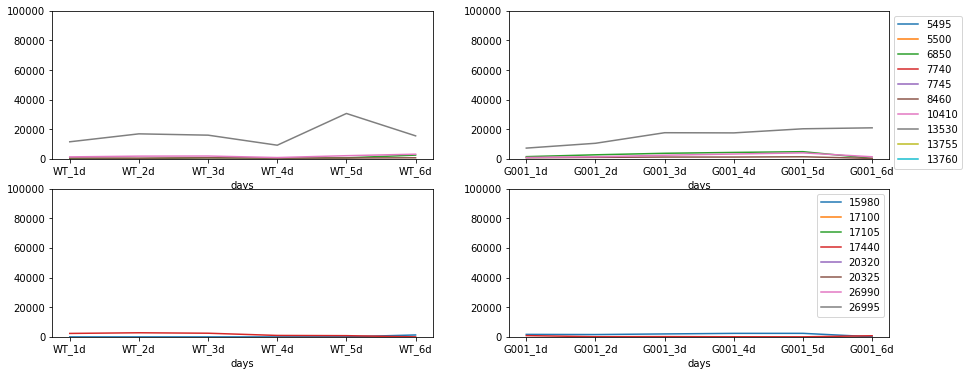

In [11]:
# Plot data
plot_df_in_parts(df_plot_fil_above)

In [12]:
# filter for genes with a similar trend as dxr cluster

# normalize to 1 for each gene
# calculate the difference between the interesting gene and each gene at each time point
# minimize that

In [13]:
df_plot_all

gene_number,5,10,15,20,30,35,45,50,55,36410,60,65,...,36190,36195,36200,36205,36210,36215,36220,37050,36235,36240,37055,36245
days,,,,,,,,,,,,,,,,,,,,,,,,,
WT_1d,1,2,1,0,0,1,7,6,2,0,0,0,...,1,0,0,0,0,3,1,0,1,0,0,0
WT_2d,1,3,1,0,0,3,22,10,6,1,0,1,...,1,0,1,0,0,6,0,3,3,0,1,0
WT_3d,0,1,0,0,0,2,13,6,5,0,1,1,...,1,0,0,1,0,6,0,1,0,0,1,0
WT_4d,1,3,2,1,1,3,24,14,12,0,3,6,...,4,2,0,0,0,4,4,2,5,4,0,4
WT_5d,0,4,1,0,0,2,51,25,21,0,1,0,...,1,0,0,1,0,7,2,3,2,0,0,0
WT_6d,4,2,1,0,1,1,80,30,11,0,0,0,...,0,0,1,0,0,11,3,2,1,0,1,0
G001_1d,1,2,3,0,0,3,36,20,6,0,0,0,...,1,0,1,0,0,14,2,3,1,0,0,0
G001_2d,3,4,2,0,1,0,47,17,15,3,1,1,...,1,0,1,0,0,9,3,2,0,0,0,0
G001_3d,2,2,2,0,0,4,69,21,24,0,2,1,...,0,0,1,1,0,10,1,1,2,0,0,0


In [93]:
num = 3
list_values = df_plot_fil_below.iloc[num,:].value_counts()

In [94]:
list_values

1      979
2      929
0      820
3      753
4      613
      ... 
235      1
231      1
331      1
82       1
355      1
Name: WT_4d, Length: 158, dtype: int64

In [89]:
list_values.sum()

7111

In [90]:
list_values.sort_index()[:10]

0    2073
1    1411
2     868
3     525
4     354
5     296
6     219
7     161
8     127
9      88
Name: WT_3d, dtype: int64

<AxesSubplot:>

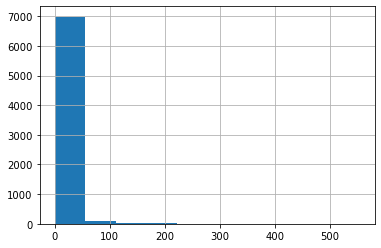

In [91]:
df_plot_fil_below.iloc[num,:].hist()